The goal of this notebook is to evaluate the performance of several state-of-the-art classifiers on the ACES RFS (Recurrence-Free Survival) data, using sample-specific coexpression networks.

We will use the same two cros-validation settings as the FERAL paper [Allahyar and de Ridder, 2015]:
* a 10-fold, subtype-stratified CV (in which the proportions of breast cancer subtypes are kept constant in each fold)
* a 12-fold, leave-one-study-out CV (in which all the samples from one study are forming a test set in turns, and half of the other studies form the corresponding training set).

We will test the following algorithms:
* L1-regularized logistic regression
* L1/L2-regularized logistic regression.

In [ ]:
# Splits for 10 repeats of 10-fold subtype-stratified CV
for repeat in {0..9}
do 
  py setUpSubTypeStratifiedCV.py ${repeat};
done

Computation on the cluster:
SamSpecCoEN/sh/qsub_run_setupSubtypeStratifiedCV_writeIndices.sh

followed by:
SamSpecCoEN/sh/qsub_run_setupSubtypeStratifiedCV_computeNetworks.sh

In [3]:
import h5py
import gzip
import sys
sys.path.append("code/")
import InnerCrossVal
import numpy as np
from sklearn import linear_model as sklm 
from sklearn import  metrics as skm
from sklearn import cross_validation as skcv 

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
orange_color = '#d66000'
blue_color = '#005599'

In [9]:
fold_nr = 5
data_dir = 'outputs/U133A_combat_RFS/subtype_stratified/repeat0/fold%d' % fold_nr
reload(InnerCrossVal)
icv = InnerCrossVal.InnerCrossVal('ACES', 
                                  data_dir, 
                                  'regline',  
                                   5, max_nr_feats=1000)

Using edge weights as features



# Using edge weights as features

In [39]:
#regParams = [10.**k for k in range(-3, 3)]
#regParams = [10.**k for k in range(-5, 1)]
regParams = [2.**k for k in range(-8, -2)]
#regParams = [np.exp(k) for k in range(-6, 0)]
print regParams
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l1', solver='liblinear', 
                                      scoring='roc_auc',
                                      class_weight='balanced')

[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125]


### Without normalization

In [ ]:
cvClassif.fit(icv.x_tr, icv.y_tr)

In [ ]:
print cvClassif.C_

In [ ]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(icv.x_tr, icv.y_tr)

In [ ]:
ytr_pred = clf.predict_proba(icv.x_tr)

In [ ]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
#print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
a = plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [ ]:
yte_pred = clf.predict_proba(icv.x_te)

In [ ]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)
plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

### With normalization

In [40]:
# Normalization
Xmean = np.mean(icv.x_tr, axis = 0)
Xstdv = np.std(icv.x_tr, axis = 0, ddof = 1)

Xtr_norm = (icv.x_tr - Xmean)/Xstdv
Xte_norm = (icv.x_te - Xmean)/Xstdv

(1455, 45068)


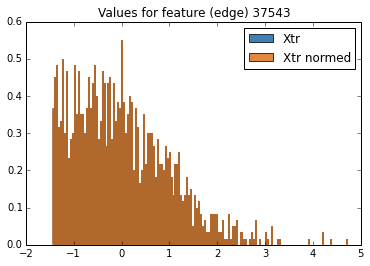

In [41]:
print icv.x_tr.shape
edge_idx=np.random.choice(np.arange(Xtr_norm.shape[1]))
a = plt.hist(icv.x_tr[:, edge_idx], normed=True, bins=150, edgecolor='none', 
            color=blue_color, alpha=0.75, label="Xtr")
a = plt.hist(Xtr_norm[:, edge_idx], normed=True, bins=150, edgecolor='none', 
            color=orange_color, alpha=0.75, label="Xtr normed")
plt.title("Values for feature (edge) %d" % edge_idx)
leg = plt.legend() 

In [42]:
cvClassif.fit(Xtr_norm, icv.y_tr)

LogisticRegressionCV(Cs=[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [43]:
print cvClassif.C_

[ 0.03125]


In [44]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(Xtr_norm, icv.y_tr)

LogisticRegression(C=0.03125, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [45]:
ytr_pred = clf.predict_proba(Xtr_norm)

410 1045


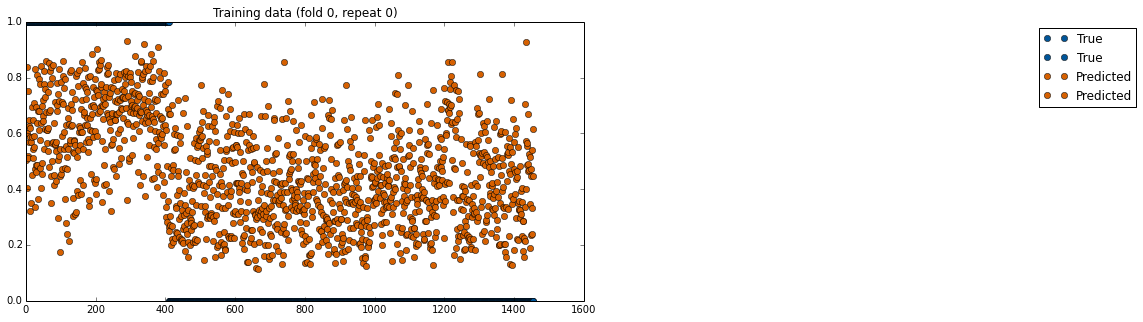

In [46]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

227 selected features


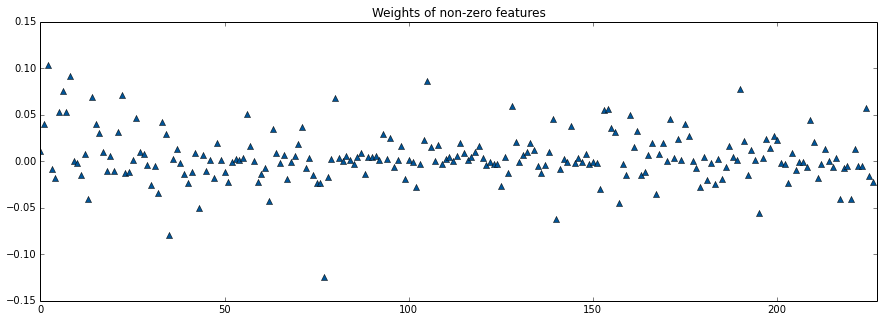

In [47]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features"

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [48]:
yte_pred = clf.predict_proba(Xte_norm)

45 116
Test AUC: 0.784865900383


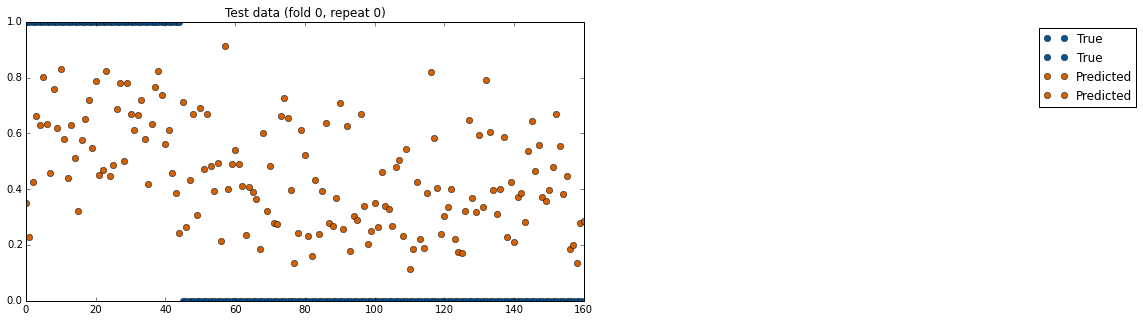

In [49]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

# Using node weights (gene expression data) as feature

In [6]:
sys.path.append('ACES')
from datatypes.ExpressionDataset import HDF5GroupToExpressionDataset

f = h5py.File("ACES/experiments/data/U133A_combat.h5")
acesData = HDF5GroupToExpressionDataset(f['U133A_combat_RFS'], checkNormalise=False)
f.close()

Z = acesData.expressionData

NOTE: HDF5GroupToExpressionDataset -- read ExpressionDataSet("U133A_combat_RFS"; 12750 genes; 1616 patients (good outcome: 1161 (71.84 %), bad outcome: 455 (28.16 %)))


In [10]:
trIndices = np.loadtxt('%s/train.indices' % data_dir, dtype='int')
teIndices = np.loadtxt('%s/test.indices' % data_dir, dtype='int')

Ztr = Z[trIndices, :]
Zte = Z[teIndices, :]

In [11]:
# Normalization
Zmean = np.mean(Ztr, axis = 0)
Zstdv = np.std(Ztr, axis = 0, ddof = 1)

Ztr_norm = (Ztr - Zmean)/Zstdv
Zte_norm = (Zte - Zmean)/Zstdv

In [ ]:
node_idx = np.random.choice(np.arange(Ztr_norm.shape[1]))
a = plt.hist(Ztr[:, node_idx], normed=True, bins=150, edgecolor='none', 
             color=blue_color, alpha=0.75, label="Ztr")
a = plt.hist(Ztr_norm[:, node_idx], normed=True, bins=150, edgecolor='none', 
             color=orange_color, alpha=0.75, label="Ztr normed")
plt.title("Values for feature (gene) %d" % node_idx)
leg = plt.legend() 

## L1-regularized logistic regression

In [50]:
regParams = [2.**k for k in range(-8, -2)]
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l1', solver='liblinear',
                                     class_weight='balanced', scoring='roc_auc')

In [51]:
cvClassif.fit(Ztr_norm, icv.y_tr)

LogisticRegressionCV(Cs=[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [52]:
print cvClassif.C_

[ 0.0625]


In [53]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l1', solver='liblinear',
                              class_weight='balanced')
clf.fit(Ztr_norm, icv.y_tr)

LogisticRegression(C=0.0625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [54]:
ytr_pred = clf.predict_proba(Ztr_norm)

410 1045


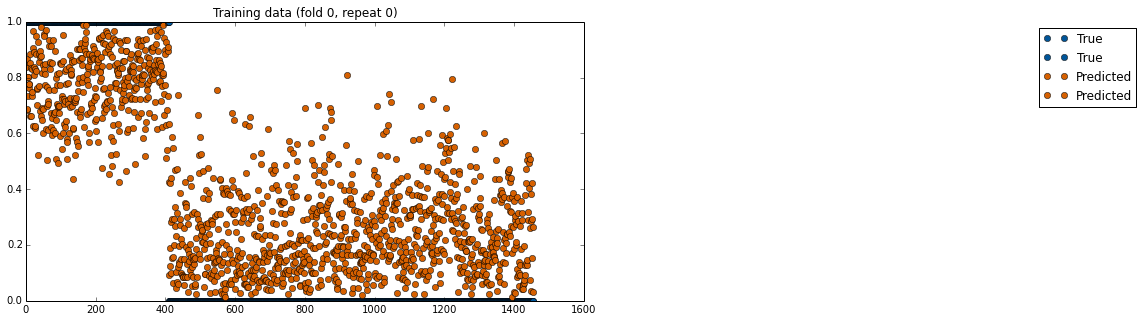

In [55]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

449 selected features.


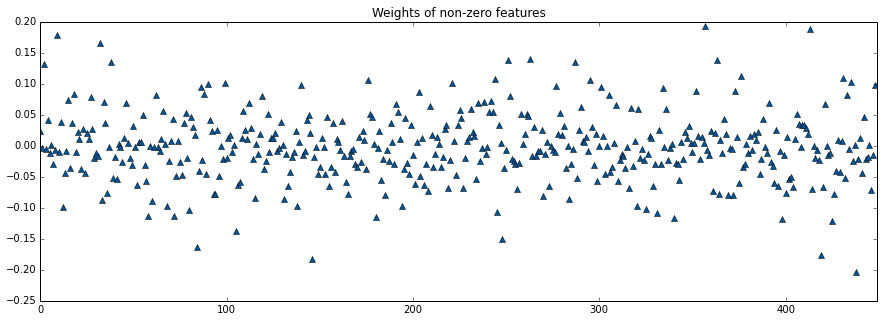

In [56]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [57]:
yte_pred = clf.predict_proba(Zte_norm)

45 116
Test AUC: 0.74214559387


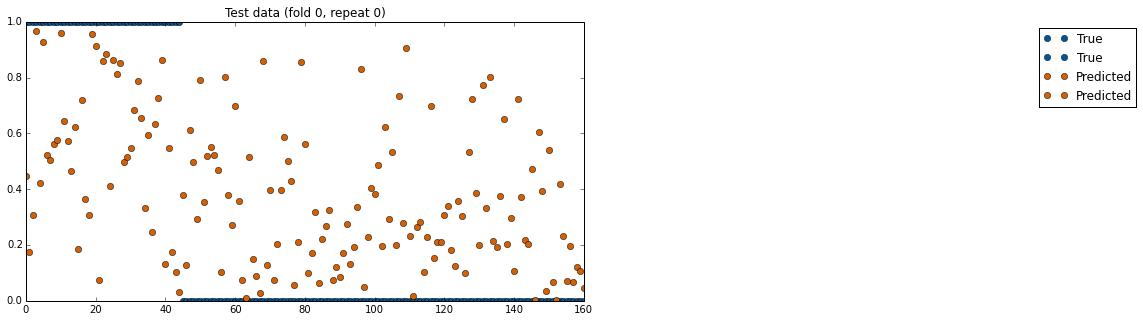

In [58]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

## Sfan

In [13]:
print Ztr.shape

(1455, 12750)


In [12]:
# Scores: Use correlation between X and phenotype (only on train data)
num_genes = Ztr_norm.shape[1]
import scipy.stats as st

scores = [st.pearsonr(Ztr_norm[:, gene_idx], icv.y_tr)[0]**2 \
          for gene_idx in range(num_genes)]

node_weights_f = "%s/scores.txt" % data_dir
np.savetxt(node_weights_f, scores, fmt='%.3e')

In [17]:
num_edges = icv.x_tr.shape[1]
edges_f = '%s/edges.gz' % data_dir
ntwk_dimacs_f = "%s/network.dimacs" % data_dir


In [23]:
# Correlation network is edges.gz (no weights)
# (for weights, go back to CoExpressionNetwork.createGlobalNetwork)
# format: <index of gene 1> <index of gene 2>
# transform into .dimacs file
sym_edges_dict = {} #j:[i]
last_idx = 0


# temporary dimacs file
import os
import tempfile

tmp_fname = 'tmp.dimacs'
fd, tmp_fname = tempfile.mkstemp()

# keep track of nodes that have at least one neighbor
connected_nodes = set([]) 

with open(tmp_fname, 'w') as g:
    g.write("p max %d %d\n" % (num_genes, num_edges*2))
    with gzip.open(edges_f, 'r') as f:     
        for line in f:
            idx_1, idx_2 = [int(x) for x in line.split()]
            # track nodes as connected
            connected_nodes.add(idx_1)
            connected_nodes.add(idx_2)
            # write edges saved in sym_edges_dict:
            for idx_3 in range(last_idx, idx_1+1):
                if sym_edges_dict.has_key(idx_3):
                    for idx_0 in sym_edges_dict[idx_3]:
                        g.write("a %d %d 1\n" % (idx_3, idx_0))
                    # delete these entries
                    del sym_edges_dict[idx_3]                   
            # update last_idx
            last_idx = idx_1            
            # write this edge
            g.write("a %d %d 1\n" % (idx_1, idx_2))
            # add to dictionary
            if not sym_edges_dict.has_key(idx_2):
                sym_edges_dict[idx_2] = []
            sym_edges_dict[idx_2].append(idx_1)
        f.close()        
        # write the end of the dictionary
        if len(sym_edges_dict):
            sym_edges_dict_keys = sym_edges_dict.keys()
            sym_edges_dict_keys.sort()
            for idx_1 in sym_edges_dict_keys:
                for idx_0 in sym_edges_dict[idx_1]:
                    g.write("a %d %d 1\n" % (idx_1, idx_0))
    g.close()           
    
# Restrict data to nodes that belong to the network:
connected_nodes = list(connected_nodes)
connected_nodes.sort()
Ztr_norm_sfan = Ztr_norm[:, connected_nodes]
Zte_norm_sfan = Zte_norm[:, connected_nodes]

num_genes_in_ntwk = len(connected_nodes)
print "%d nodes in the network." % num_genes_in_ntwk

# Map node IDs in temporary dimacs to the final ones
map_idx = {}        
for (old_idx, new_idx) in zip(connected_nodes, range(num_genes_in_ntwk)):
    map_idx[old_idx] = new_idx + 1 # indices start at 1 in dimacs file                                      

# Update node IDs in ntwk_dimacs
with open(ntwk_dimacs_f, 'w') as g:
    g.write("p max %d %d\n" % (num_genes_in_ntwk, num_edges*2))
    with open(tmp_fname, 'r') as f:
        f.readline() # header
        for line in f:
            ls = line.split()
            g.write("a %d %d %s\n" % (map_idx[int(ls[1])], map_idx[int(ls[2])], ls[3]))
        f.close()
    g.close()
    
# Delete temporary file
os.remove(tmp_fname)        

4010 nodes in the network.


In [64]:
# Run sfan 
import subprocess
lbd = '0.10'
eta = '0.01'

msfanpy = "/home/cazencott/Research/Projects/sfan/code/multitask_sfan.py"
argum = ['python', msfanpy, '--num_tasks', '1',
         '--networks', ntwk_dimacs_f, 
         '--node_weights', node_weights_f,
         '-l', lbd, '-e', eta, '-m', '0']
print "Running: ", " ".join(argum)
p = subprocess.Popen(argum, stdout=subprocess.PIPE)
#print p.communicate()
p_out = p.communicate()[0].split("\n")[2]
#print p_out
sel_list = [(int(x)-1) for x in p_out.split()]

# Look at selected features
print len(sel_list), "selected features."

Running:  python /home/cazencott/Research/Projects/sfan/code/multitask_sfan.py --num_tasks 1 --networks outputs/U133A_combat_RFS/subtype_stratified/repeat0/fold5/network.dimacs --node_weights outputs/U133A_combat_RFS/subtype_stratified/repeat0/fold5/scores.txt -l 0.10 -e 0.01 -m 0
69 selected features.


In [30]:
# Train a ridge-logistic-regression on the selected features
Ztr_sel = Ztr_norm_sfan[:, sel_list]
Zte_sel = Zte_norm_sfan[:, sel_list]

regParams = [2.**k for k in range(-8, -2)]
cvClassif = sklm.LogisticRegressionCV(Cs=regParams, penalty='l2', solver='liblinear',
                                     class_weight='balanced', scoring='roc_auc')

In [31]:
cvClassif.fit(Ztr_sel, icv.y_tr)

LogisticRegressionCV(Cs=[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125],
           class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [32]:
print cvClassif.C_

[ 0.00390625]


In [33]:
optimalC = cvClassif.C_[0]
clf = sklm.LogisticRegression(C=optimalC, penalty='l2', solver='liblinear',
                              class_weight='balanced')
clf.fit(Ztr_sel, icv.y_tr)

LogisticRegression(C=0.00390625, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
ytr_pred = clf.predict_proba(Ztr_sel)

410 1045


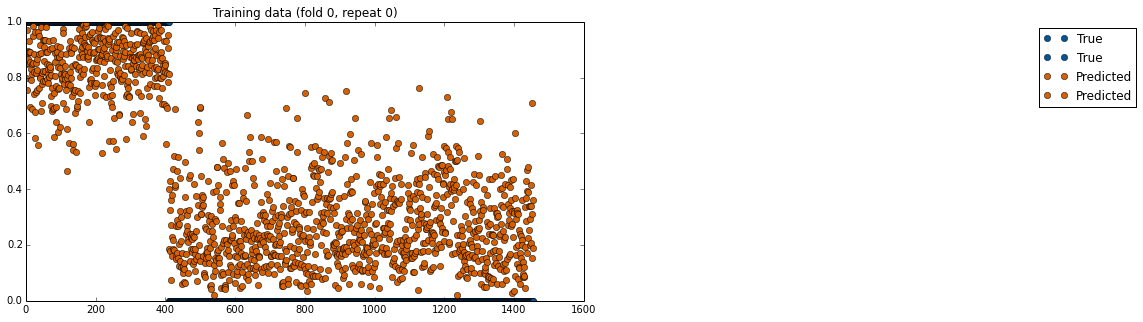

In [35]:
ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.y_tr > 0)[0]
tr_neg_indices = np.where(icv.y_tr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.y_tr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.y_tr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

3940 selected features.


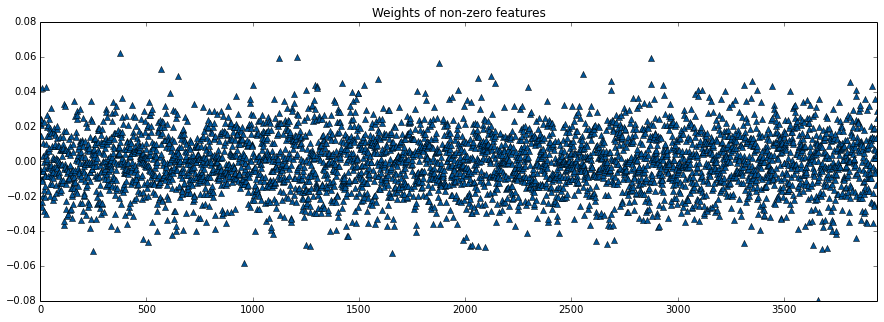

In [36]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features."

plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='^', ls='')
plt.title("Weights of non-zero features")
a = plt.xlim(-0.1, len(features)+0.1)

In [37]:
yte_pred = clf.predict_proba(Zte_sel)

45 116
Test AUC: 0.763409961686


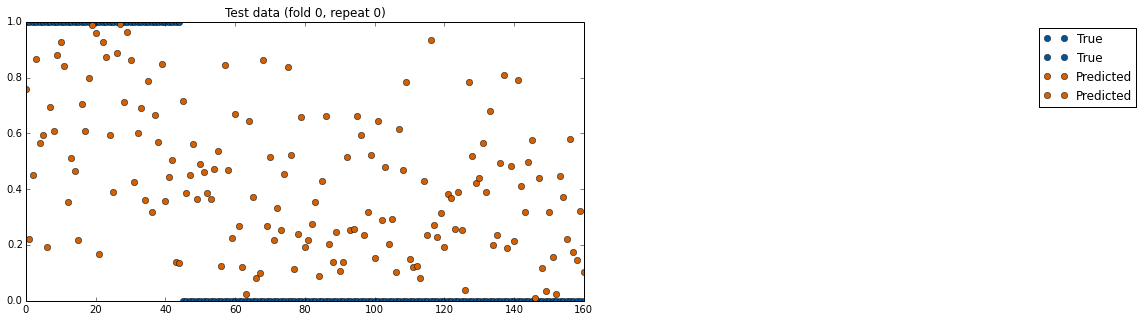

In [38]:
te_pos_indices = np.where(icv.y_te > 0)[0]
te_neg_indices = np.where(icv.y_te == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.y_te[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.y_te[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='o', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "Test AUC:", skm.roc_auc_score(icv.y_te, yte_pred[:, ix])

## Elastic Net 

In [ ]:
print [2.**k for k in range(-8, -2)]
print [2.**k for k in range(-6, -3)]

In [ ]:
# Grid search Elastic Net (for classification)
#alpha_values = [2.**k for k in range(-8, -2)]
l1_ratio_values = [.1, .5, .7, .9, .95, .99]
#l1_ratio_values = [float(k+1)/7 for k in range(6)]

#lbd_values = [2.**k for k in range(-6, -3)] #[2.**k for k in range(-8, -2)]
lbd_values = [10.**k for k in range(-7, -2)]

auc_dict = {} # auc:params

cross_validator = skcv.StratifiedKFold(icv.Ytr, 5)

# for alpha in alpha_values:
for lbd in lbd_values:
     for l1_ratio in l1_ratio_values:
        alpha = lbd / l1_ratio

        clf = sklm.SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio)
        y_true = []
        y_pred = []
        for tr, te in cross_validator:
            clf.fit(icv.Xtr[tr, :], icv.Ytr[tr])
            ytr_te_pred = clf.predict_proba(icv.Xtr[te, :])
            ix = clf.classes_.tolist().index(1)
            y_pred.extend(ytr_te_pred[:, ix])
            y_true.extend(icv.Ytr[te])            
            
        auc = skm.roc_auc_score(y_true, y_pred)
        print "alpha", alpha, "\tl1_ratio", l1_ratio, "\tauc", auc
        if not auc_dict.has_key(auc):
            auc_dict[auc] = []
        auc_dict[auc].append([alpha, l1_ratio])

auc_values = auc_dict.keys()
auc_values.sort()
best_auc = auc_values[-1]
print "Best AUC: ", best_auc

print auc_dict[best_auc]               

In [ ]:
# Run Elastic Net
alpha = auc_dict[best_auc][0][0]
l1_ratio = auc_dict[best_auc][0][1]

clf = sklm.SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha, l1_ratio=l1_ratio)

clf.fit(icv.Xtr, icv.Ytr)
ytr_pred = clf.predict_proba(icv.Xtr)

ix = clf.classes_.tolist().index(1)
tr_pos_indices = np.where(icv.Ytr > 0)[0]
tr_neg_indices = np.where(icv.Ytr == 0)[0]
print len(tr_pos_indices), len(tr_neg_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(tr_pos_indices)), icv.Ytr[tr_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), icv.Ytr[tr_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(tr_pos_indices)), ytr_pred[tr_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.plot(range(len(tr_pos_indices), len(tr_pos_indices)+len(tr_neg_indices)), ytr_pred[tr_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.title("Training data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))

In [ ]:
features = np.where(clf.coef_[0])[0]
print len(features), "selected features"
plt.figure(figsize=(15, 5))
plt.plot(range(len(features)), clf.coef_[0][features],
            color=blue_color, marker='+', ls='')

In [ ]:
yte_pred = clf.predict_proba(icv.Xte)
te_pos_indices = np.where(icv.Yte > 0)[0]
te_neg_indices = np.where(icv.Yte == 0)[0]
print len(te_pos_indices), len(te_neg_indices)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(te_pos_indices)), icv.Yte[te_pos_indices], 
         color=blue_color, label='True', marker='o', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), icv.Yte[te_neg_indices], 
         color=blue_color, label='True', marker='o', ls='')
    
plt.plot(range(len(te_pos_indices)), yte_pred[te_pos_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.plot(range(len(te_pos_indices), len(te_pos_indices)+len(te_neg_indices)), yte_pred[te_neg_indices, ix], 
         color=orange_color, label='Predicted', marker='+', ls='')
plt.title("Test data (fold 0, repeat 0)")
plt.legend(bbox_to_anchor=(1, 0, 1, 1))
print "AUC:", skm.roc_auc_score(icv.Yte, yte_pred[:, ix])